In [1]:
#This is the works for Udacity Self-driving-car-nd Term1 Project 3.
%matplotlib inline
import os, sys, random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

In [2]:
# Print iterations progress
def print_progress(iteration, total):
    """
    Call in a loop to create terminal progress bar
    
    Parameters
    ----------
        
    iteration : 
                Current iteration (Int)
    total     : 
                Total iterations (Int)
    """
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

### Dataset

In [3]:
#Load sample data
Folder_path = "./dataset/behavioral-cloning/sample_data/"
Img_path = Folder_path + "IMG/"
df = pd.read_csv(Folder_path + "driving_log.csv")

df['left'] = df['left'].str.replace(' IMG/','./dataset/behavioral-cloning/sample_data/IMG/')
df['right'] = df['right'].str.replace(' IMG/','./dataset/behavioral-cloning/sample_data/IMG/')
df['center'] = df['center'].str.replace('IMG/','./dataset/behavioral-cloning/sample_data/IMG/')

In [4]:
Folder_path = "./dataset/behavioral-cloning/train_data_new/"
Img_path = Folder_path + "IMG/"
df = pd.read_csv(Folder_path + "driving_log.csv", names=['center', 'left', 'right', 'steering', 'gas', 'brake', 'speed'])

df['left'] = df['left'].str.replace('/home/jaeoh2/Tools/linux_sim/','./dataset/behavioral-cloning/')
df['right'] = df['right'].str.replace('/home/jaeoh2/Tools/linux_sim/','./dataset/behavioral-cloning/')
df['center'] = df['center'].str.replace('/home/jaeoh2/Tools/linux_sim/','./dataset/behavioral-cloning/')

In [5]:
df

,center,left,right,steering,gas,brake,speed
0,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,-0.052632,1.000000,0.0,30.19027
1,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,-0.052632,1.000000,0.0,30.19027
2,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,-0.052632,1.000000,0.0,30.19024
3,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,-0.052632,1.000000,0.0,30.19024
4,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,-0.052632,1.000000,0.0,30.19026
5,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,-0.052632,1.000000,0.0,30.19024
6,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,0.000000,1.000000,0.0,30.19023
7,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,0.030075,1.000000,0.0,30.18975
8,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,0.030075,1.000000,0.0,30.18998
9,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,./dataset/behavioral-cloning/train_data_new/IM...,0.030075,1.000000,0.0,30.19011


In [6]:
#data balancing refer from https://navoshta.com/end-to-end-deep-learning/
balanced = pd.DataFrame()
bins = 200
bin_n = 200

start = 0
for end in np.linspace(0, 1, num=bins):
    df_range = df[(np.absolute(df.steering) >= start) & (np.absolute(df.steering) < end)]
    range_n = min(bin_n, df_range.shape[0])
    if range_n > 0:
        balanced = pd.concat([balanced, df_range.sample(range_n)])
    start = end
balanced.to_csv(Folder_path + 'driving_log_balanced.csv', index=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f736b854198>]], dtype=object)

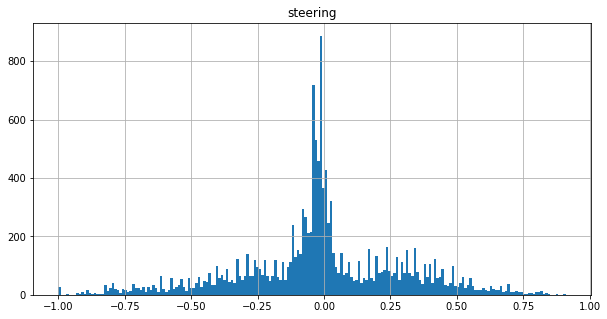

In [7]:
df.hist(column=['steering'], bins=bins, figsize=(10,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f736b0b46a0>]], dtype=object)

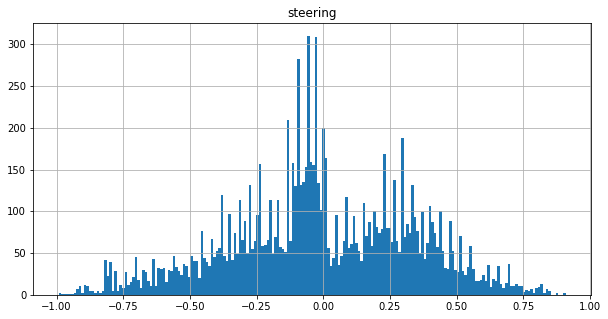

In [8]:
balanced.hist(column=['steering'], bins=bins, figsize=(10,5))

In [9]:
num_examples = len(df)
num_balanced = len(balanced)
print("Number of examples : {}\nNumber of balanced : {}".format(num_examples, num_balanced))

Number of examplese : 13977
Number of balanced : 10775


### Data Augmentation

In [10]:
import random
import os, sys
import csv
from skimage.transform import rotate, warp, ProjectiveTransform, AffineTransform
import cv2

In [11]:
def random_translate(X, steer, intensity=1):
    delta = 15.* intensity
    rand_delta = random.uniform(-delta, delta)
    translate_matrix = AffineTransform(translation=(rand_delta, 0))
    X = warp(X,translate_matrix)
    steer += rand_delta*0.01
    return X, steer

(<matplotlib.axes._subplots.AxesSubplot at 0x7f730b5616d8>,
 (-0.5, 319.5, 159.5, -0.5))

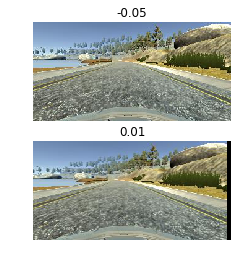

In [12]:
#test
ran_idx = random.randint(0, num_examples)
test_img = mpimg.imread(df.center[ran_idx])
test_str = float(df.steering[ran_idx])
test_rt_img, test_rt_str = random_translate(test_img, test_str)
plt.subplot(2,1,1), plt.imshow(test_img), plt.title(round(test_str,2)), plt.axis('off')
plt.subplot(2,1,2), plt.imshow(test_rt_img), plt.title(round(test_rt_str,2)), plt.axis('off')

In [13]:
def image_flip(X, steer):
    img_fliped = np.fliplr(X)
    str_fliped = -steer
    return img_fliped, str_fliped

(<matplotlib.axes._subplots.AxesSubplot at 0x7f730b425e48>,
 (-0.5, 319.5, 159.5, -0.5),
 <matplotlib.text.Text at 0x7f7309b93518>)

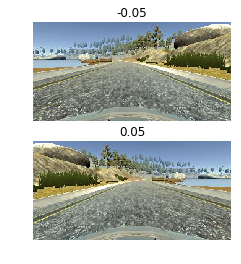

In [14]:
#test
test_fl_img, test_fl_str = image_flip(test_img, test_str)
plt.subplot(2,1,1), plt.imshow(test_img), plt.axis('off'), plt.title(round(test_str,2))
plt.subplot(2,1,2), plt.imshow(test_fl_img), plt.axis('off'), plt.title(round(test_fl_str,2))

In [15]:
def random_rotate(X,intensity=3):
    delta = np.radians(intensity) #deg to rad
    rand_delta = random.uniform(-delta, delta) #rotate range
    rotate_matrix = AffineTransform(rotation=rand_delta)
    X = warp(X, rotate_matrix)
    return X

In [16]:
def random_brightness(image):
    #Convert 2 HSV colorspace from RGB colorspace
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    #Generate new random brightness
    rand = random.uniform(0.3,1.0)
    hsv[:,:,2] = rand*hsv[:,:,2]
    #Convert back to RGB colorspace
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return new_img 

In [17]:
def random_shadow(image):
    #refer from : https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    shadow_mask = 0*hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    if np.random.randint(2) == 1:
        random_bright = 0.5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            hls[:,:,1][cond1] = hls[:,:,1][cond1]*random_bright
        else:
            hls[:,:,1][cond0] = hls[:,:,1][cond0]*random_bright
        
    img = cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)
    
    return img

In [18]:
import math
import cv2
height=64
width=64
def preprocess_image(X):
    X = cv2.resize(X[60:140,:], (width,height), interpolation=cv2.INTER_AREA)
    #X = cv2.cvtColor(X, cv2.COLOR_RGB2YUV)
    
    return X

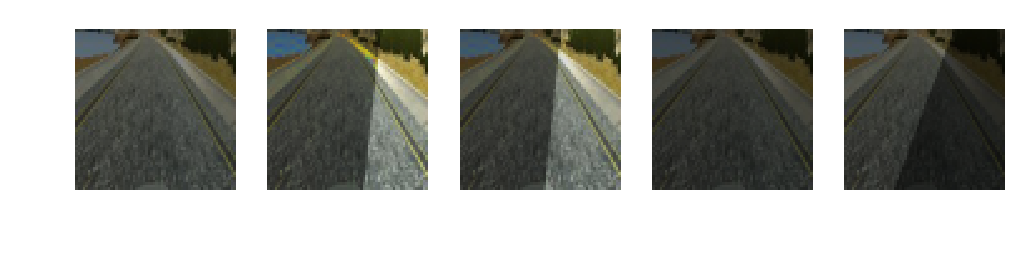

In [19]:
#test
plt.figure(dpi=200)
for i in range(5):
    test_resize_img = random_brightness(test_img)
    test_resize_img = random_shadow(test_resize_img)
    test_resize_img = preprocess_image(test_resize_img)
    plt.subplot(1,5,i+1), plt.imshow(test_resize_img), plt.axis('off')

In [20]:
center = df.center.tolist()
left = df.left.tolist()
right = df.right.tolist()
steering = df.steering.tolist()
leftsteering = (df.steering + 0.25).tolist()
rightsteering = (df.steering - 0.25).tolist()

In [21]:
center = balanced.center.tolist()
left = balanced.left.tolist()
right = balanced.right.tolist()
steering = balanced.steering.tolist()
leftsteering = (balanced.steering + 0.25).tolist()
rightsteering = (balanced.steering - 0.25).tolist()

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_train = center + left + right
y_train = steering + leftsteering + rightsteering

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [23]:
def transform_images(X, y):
    #X = random_brightness(X)
    #X = random_shadow(X)
    #X = random_rotate(X)
    if np.random.randint(2) == 0:
        X, y = image_flip(X, y)
    #X,y = random_translate(X, y, intensity=1)
    X = preprocess_image(X)
    return X,y

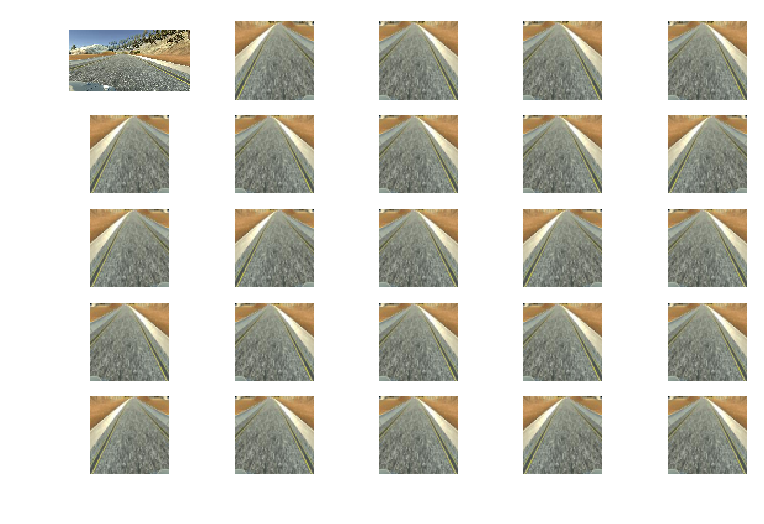

In [24]:
#test
plt.figure(dpi=150)
for i in range(5):
    test_img = mpimg.imread(X_train[0])
    plt.subplot(5,5,i+1),plt.imshow(transform_images(test_img, y_train[0])[0]),plt.axis('off')
    plt.subplot(5,5,i+6),plt.imshow(transform_images(test_img, y_train[0])[0]),plt.axis('off')
    plt.subplot(5,5,i+11),plt.imshow(transform_images(test_img, y_train[0])[0]),plt.axis('off')
    plt.subplot(5,5,i+16),plt.imshow(transform_images(test_img, y_train[0])[0]),plt.axis('off')
    plt.subplot(5,5,i+21),plt.imshow(transform_images(test_img, y_train[0])[0]),plt.axis('off')
    plt.subplot(5,5,1),plt.imshow(test_img),plt.axis('off')

In [25]:
def get_transform_images(Xs, ys, n_each=10):
        
    X_arr = []
    y_arr = []
    
    
    #Parallel(n_jobs=nprocs)(delayed(preprocess_image)(imfile) for imfile in Xs)
    
    for i, (x, y) in enumerate(zip(Xs,ys)):
        for _ in range(n_each):
            img = mpimg.imread(x)
            img_trf, label_trf = transform_images(img, y)
            X_arr.append(img_trf)
            y_arr.append(label_trf)
        
        print_progress(i+1, len(Xs))
        
    X_arr = np.asarray(X_arr, dtype=np.float32)
    y_arr = np.asarray(y_arr, dtype=np.float32)
    
    return X_arr, y_arr    

In [26]:
X_trf, y_trf = get_transform_images(X_train, y_train, n_each=10)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%


In [27]:
X_trf_val, y_trf_val = get_transform_images(X_valid, y_valid, n_each=1)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%


In [28]:
X_trf.shape, y_trf.shape, X_trf_val.shape, y_trf_val.shape

((258600, 64, 64, 3), (258600,), (6465, 64, 64, 3), (6465,))

In [29]:
print("Saving preprocessed Train images")
#np.save(Folder_path + "TrainX.npy", X_trf)
#np.save(Folder_path + "Trainy.npy", y_trf)
#np.save(Folder_path + "ValidX.npy", X_trf_val)
#np.save(Folder_path + "Validy.npy", y_trf_val)
print("Saving Done")

Saving preprocessed Train images
Saving Done


In [30]:
X_train, y_train, X_valid, y_valid = X_trf, y_trf, X_trf_val, y_trf_val

### Model

In [31]:
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPool2D
from keras.layers import Dense, Dropout, Flatten, Cropping2D
from keras.optimizers import adam

Using TensorFlow backend.


In [32]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.layers import Lambda

In [33]:
#Model Configurations
img_height = 64
img_width = 64
img_ch = 3

f_size = 3
learning_rate = 1e-2
activation = 'elu'

In [34]:
def build_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/255. -0.5, input_shape=(img_height, img_width, img_ch)))
    model.add(Conv2D(16,(3,3), activation=activation, padding='valid'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(32,(3,3), activation=activation, padding='valid'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(64,(3,3), activation=activation, padding='valid'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(500, activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation=activation))
    model.add(Dropout(0.25))
    model.add(Dense(20, activation=activation))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    
    model.summary()
    #model = make_parallel(model,2)
    model.compile(loss='MSE', optimizer='adam', metrics=['accuracy'])
    
    return model


In [35]:
model = build_model()
model_checkpoint = ModelCheckpoint('model.h5', monitor='loss', save_best_only=True)
model_earlystopping = EarlyStopping(monitor='loss')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [36]:
import numpy as np
#Folder_path = "./dataset/behavioral-cloning/sample_data/"
#Folder_path = "./dataset/behavioral-cloning/train_data/"

#X_train = np.load(Folder_path + "TrainX.npy")
#y_train = np.load(Folder_path + "Trainy.npy")
#X_valid = np.load(Folder_path + "ValidX.npy")
#y_valid = np.load(Folder_path + "Validy.npy")

In [37]:
model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, shuffle=True,
          validation_data=(X_valid, y_valid),
         callbacks=[model_checkpoint, model_earlystopping])

Train on 258600 samples, validate on 6465 samples
Epoch 1/5
258600/258600 [==============================] - 73s - loss: 0.0410 - acc: 0.0060 - val_loss: 0.0288 - val_acc: 0.0068
Epoch 2/5
258600/258600 [==============================] - 71s - loss: 0.0237 - acc: 0.0060 - val_loss: 0.0235 - val_acc: 0.0068


In [38]:
with open('model.json', 'w') as file:
        file.write(model.to_json())